<a href="https://colab.research.google.com/github/sweathaamarnath/Autonomous/blob/main/Lane_detection_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries for building the model

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Activation, Dropout, UpSampling2D, Input
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate, add
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
from tensorflow.python.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the resized image (128,128,3) and masked image(128,128,1) of the public dataset

In [ ]:
train_images = pickle.load(open("/content/drive/My Drive/images.pkl", "rb" ))
labels = pickle.load(open("/content/drive/My Drive/labels.pkl", "rb" ))

In [ ]:
train_images = np.array(train_images)
labels = np.array(labels)

In [ ]:
labels.shape

(12764, 128, 128)

#Shuffle and data split into train and validation set

In [ ]:
# Normalize labels - training images get normalized to start in the network
labels = labels / 255

# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

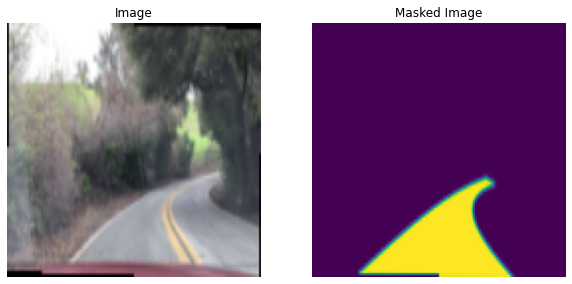

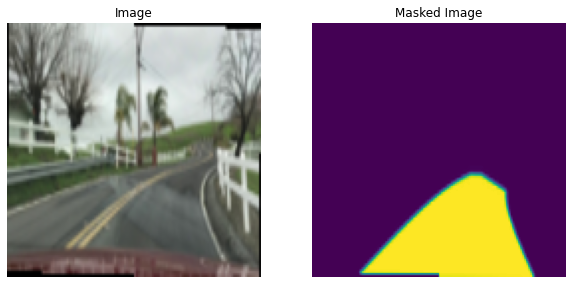

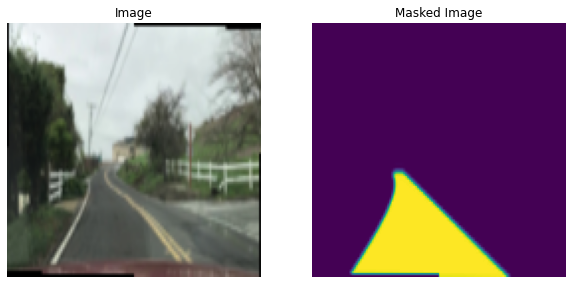

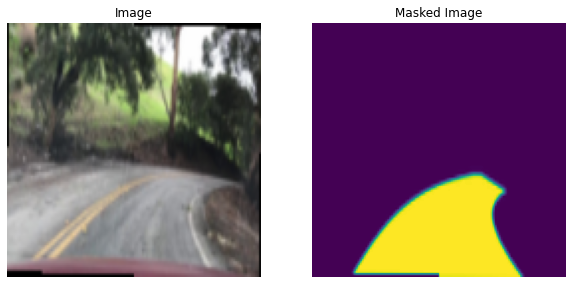

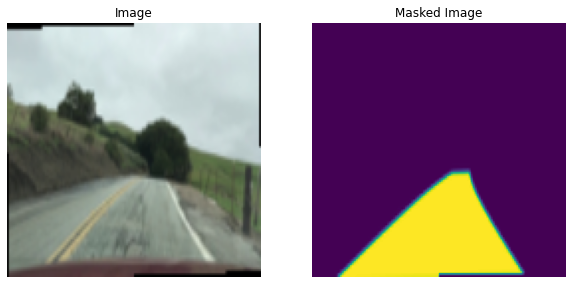

In [ ]:
for i in range(5):
  fig, ax = plt.subplots(1, 2, figsize=(10,7))
  ax[0].imshow(train_images[i])
  ax[0].axis("off")
  ax[0].set_title("Image")

  ax[1].imshow(labels[i])
  ax[1].axis("off")
  ax[1].set_title("Masked Image")

  plt.show()

In [ ]:
X_train.shape

(11487, 128, 128, 3)

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_val.shape

(1277, 128, 128, 3)

#Unet model

In [ ]:
  def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    return x
  
  def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [ ]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

input_img = Input((128, 128, 3), name='input_img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=["accuracy"])

#Train the model

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_val)//BATCH_SIZE//VAL_SUBSPLITS

model_history =  model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), steps_per_epoch=len(X_train)/BATCH_SIZE,epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
359/358 [==============================] - 16s 45ms/step - loss: 0.1440 - accuracy: 0.9325 - val_loss: 0.0592 - val_accuracy: 0.9452
Epoch 2/10
359/358 [==============================] - 15s 43ms/step - loss: 0.0414 - accuracy: 0.9457 - val_loss: 0.0325 - val_accuracy: 0.9459
Epoch 3/10
359/358 [==============================] - 15s 43ms/step - loss: 0.0300 - accuracy: 0.9462 - val_loss: 0.0267 - val_accuracy: 0.9464
Epoch 4/10
359/358 [==============================] - 15s 43ms/step - loss: 0.0265 - accuracy: 0.9464 - val_loss: 0.0246 - val_accuracy: 0.9464
Epoch 5/10
359/358 [==============================] - 15s 43ms/step - loss: 0.0239 - accuracy: 0.9467 - val_loss: 0.0237 - val_accuracy: 0.9465
Epoch 6/10
359/358 [==============================] - 15s 43ms/step - loss: 0.0225 - accuracy: 0.9468 - val_loss: 0.0220 - val_accuracy: 0.9466
Epoch 7/10
359/358 [==============================] - 15s 43

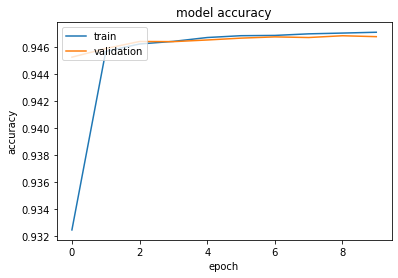

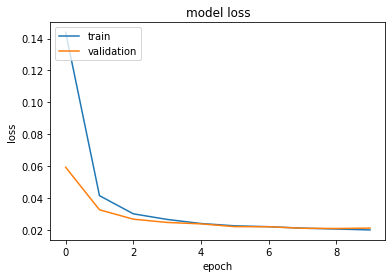

In [ ]:
import matplotlib.pyplot as plt
#  "Accuracy"
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Test the model prediction

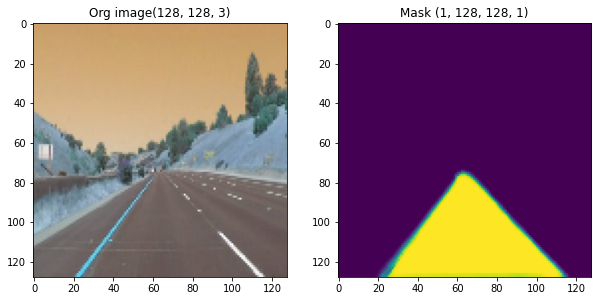

In [ ]:
import cv2 

img = cv2.imread("/content/drive/My Drive/solidYellowCurve2.jpg")
img = cv2.resize(img, (128,128))
img = np.array(img)
z = model.predict(img[tf.newaxis, ...])

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(121)
ax.set_title(f'Org image{img.shape}')
ax.imshow(img)

ax2 = fig.add_subplot(122)
ax2.set_title(f'Mask {z.shape}')
ax2.imshow(tf.squeeze(z))

In [ ]:
model.save('udacity_custom_model.h5')